In [1]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd

# Anomalies

In this homework we will look at some simple examples of detecting anomalies in time series. But first, let's try to define, what anomaly is.

In general, **anomaly** is an observable behaviour of the system, which contradicts the underlying dynamics, which we believe is driving the system. Of course, any observable, normal or anomalous, is generated by underlying system dynamics. The real reason we consider some behaviours as normal and some as anomalous is that we use not a real dynamics to describe the system, but either some model, or we want system to demostrate certain desired behaviour.

For example:

- unusually high power consumption in electrical grid may be caused by unusual weather conditions for a certain season, and is thus an absolutely explainable, but grid operator still considers this situation as an anomaly, because unusually high consumption is not a desirable behaviour,
- presense of unusual patterns in sensor reading of industrial equipment may be an indication of some failure coming. In this case, anomaly is not manifested as some extremely high or low way, but rather as an unusual pattern.

In this homework we will consider two datasets:

- [hourly energy consumption data from PJM transmission operator](https://www.kaggle.com/robikscube/hourly-energy-consumption),
- ECG data from [MIT-BIH Arrhythmia Database](https://www.kaggle.com/mondejar/mitbih-database).

# Data

For the first exercise, we will take specific area, served by Commonwealth Edison energy producer. The area is Chicago and part of Illinois. We will look at the data to understand, when consumption is anomalous and will try to explain this anomalies to some extent.

In [3]:
COMED_path = "./hourly-energy-consumption/COMED_hourly.csv"

In [4]:
data = pd.read_csv(COMED_path,
                   parse_dates=["Datetime"],
                   index_col="Datetime")

In [5]:
data.head()

,COMED_MW
Datetime,
2011-12-31 01:00:00,9970.0
2011-12-31 02:00:00,9428.0
2011-12-31 03:00:00,9059.0
2011-12-31 04:00:00,8817.0
2011-12-31 05:00:00,8743.0


Let's clean-up the field a bit first:

In [6]:
data.rename({"COMED_MW":"cons_mw"}, axis=1, inplace=True)
data.index.name = "dt"

## Quick exploration

Data definitely demostrates strong seasonality with consumption being higher at summer (air conditioning, apperantly) and during winter (electrical heating, lights etc.):

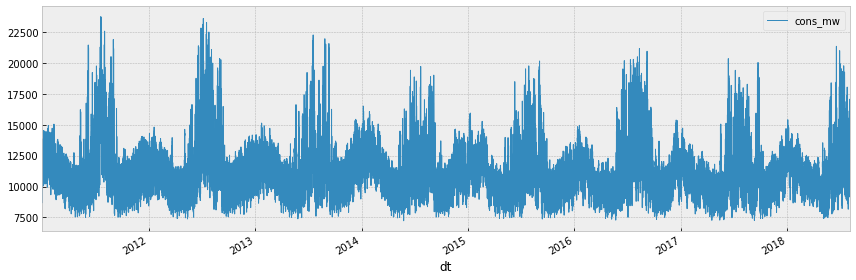

In [7]:
plt.figure(figsize=(12,4))
data.plot(linewidth=1, ax=plt.gca())
plt.tight_layout()

If we try to calculate rolling average of the data, we will fail, cause original data is not ordered:

In [8]:
# data.sort_values(by=['Datetime'], inplace=True)
data.rolling("7D").mean()

ValueError: index must be monotonic

In [28]:
data.index.to_series().diff().head(30)

dt
2011-12-31 01:00:00                 NaT
2011-12-31 02:00:00     0 days 01:00:00
2011-12-31 03:00:00     0 days 01:00:00
2011-12-31 04:00:00     0 days 01:00:00
2011-12-31 05:00:00     0 days 01:00:00
2011-12-31 06:00:00     0 days 01:00:00
2011-12-31 07:00:00     0 days 01:00:00
2011-12-31 08:00:00     0 days 01:00:00
2011-12-31 09:00:00     0 days 01:00:00
2011-12-31 10:00:00     0 days 01:00:00
2011-12-31 11:00:00     0 days 01:00:00
2011-12-31 12:00:00     0 days 01:00:00
2011-12-31 13:00:00     0 days 01:00:00
2011-12-31 14:00:00     0 days 01:00:00
2011-12-31 15:00:00     0 days 01:00:00
2011-12-31 16:00:00     0 days 01:00:00
2011-12-31 17:00:00     0 days 01:00:00
2011-12-31 18:00:00     0 days 01:00:00
2011-12-31 19:00:00     0 days 01:00:00
2011-12-31 20:00:00     0 days 01:00:00
2011-12-31 21:00:00     0 days 01:00:00
2011-12-31 22:00:00     0 days 01:00:00
2011-12-31 23:00:00     0 days 01:00:00
2012-01-01 00:00:00     0 days 01:00:00
2011-12-30 01:00:00   -2 days +01:00:

In [29]:
data = data.sort_index()

In [30]:
data.rolling("7D").mean()

,cons_mw
dt,
2011-01-01 01:00:00,9631.000000
2011-01-01 02:00:00,9452.000000
2011-01-01 03:00:00,9305.000000
2011-01-01 04:00:00,9164.000000
2011-01-01 05:00:00,9070.000000
...,...
2018-08-02 20:00:00,12035.815476
2018-08-02 21:00:00,12045.607143
2018-08-02 22:00:00,12054.297619


# Naive anomalies detection

The first and the most simple way to catch unusually high or low values is to just look at rolling average and rolling standard deviation. The assumation is that for a reasonably short period we can use usual statistical approaches, and to say
> if it's outside 3$\sigma$, it's an anomaly

is still somewhat reliable. Let's look at the data at a weekly scale:

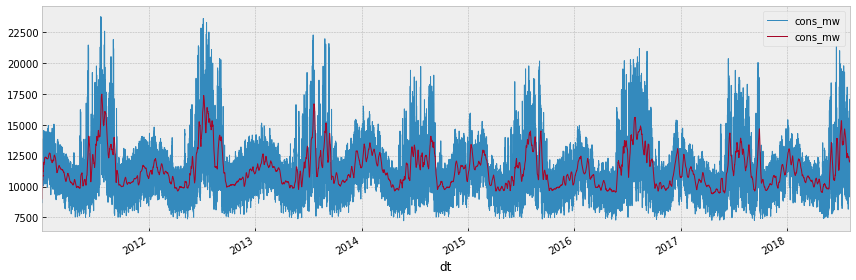

In [39]:
plt.figure(figsize=(12,4))

data.plot(linewidth=1, ax=plt.gca(), label="a") #, color='b'


data.rolling("7D").mean().plot(linewidth=1, ax=plt.gca())

plt.legend(loc=0)
plt.tight_layout()

If we look at the same data on a monthly scale and add "normal" range ($3\sigma$ from rolling average in any direction), we'll start to see hours, which go to high:

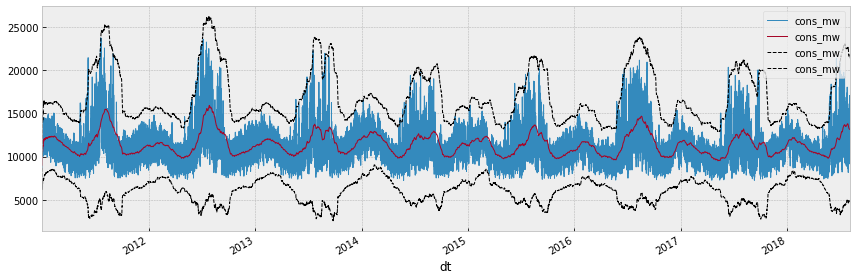

In [37]:
plt.figure(figsize=(12,4))

data.plot(linewidth=1, ax=plt.gca())

(data
 .rolling("30D")
 .mean()
 .plot(linewidth=1, ax=plt.gca(), label="rolling average"))

((data.rolling("30D").mean()+3*data.rolling("30D").std())
 .plot(linewidth=1, linestyle="--", color="k", ax=plt.gca(), label="rolling average"))

((data.rolling("30D").mean()-3*data.rolling("30D").std())
 .plot(linewidth=1, linestyle="--", color="k", ax=plt.gca(), label="rolling average"))

plt.legend(loc=0)
plt.tight_layout()

Let's create a funtion, which searches for such points and creates new dataframe with anomaly indication:

In [40]:
def detect_anomalies(series, window, factor):
    """Mark all the anomalies, i.e. points, which are outside of `factor*std` range."""

    series_mean = series.rolling(window).mean()
    series_std = series.rolling(window).std()

    result = pd.concat([series,
                        series_mean.rename("_".join([series.name, "rmean"]))],
                       axis=1)
    result = result.join(series_std.rename("_".join([series.name, "rstd"])))
    anomaly = ((series-series_mean)>factor*series_std).astype(int)
    result = result.join(anomaly.rename("anomaly"))
    return result

In [41]:
data_an = detect_anomalies(data["cons_mw"], "30D", 3.)

In [42]:
data_an.head()

,cons_mw,cons_mw_rmean,cons_mw_rstd,anomaly
dt,,,,
2011-01-01 01:00:00,9631.0,9631.0,NaN,0
2011-01-01 02:00:00,9273.0,9452.0,253.144228,0
2011-01-01 03:00:00,9011.0,9305.0,311.236245,0
2011-01-01 04:00:00,8741.0,9164.0,379.608570,0
2011-01-01 05:00:00,8694.0,9070.0,390.201230,0


In [43]:
def plot_anomalies(df, d_col, m_col, s_col, a_col, factor):
    """Plot data and annotations."""

    plt.figure(figsize=(12,4))

    # Plot original data
    df[d_col].plot(linewidth=1, ax=plt.gca())

    # Plot rolling average
    df[m_col].plot(linewidth=1, ax=plt.gca())

    # Plot "normal" range
    (df[m_col]+factor*df[s_col]).plot(linewidth=1, c="k", linestyle="--", ax=plt.gca())
    (df[m_col]-factor*df[s_col]).plot(linewidth=1, c="k", linestyle="--", ax=plt.gca())

    # Plo anomalies
    df.loc[df[a_col]==1, d_col].plot(linewidth=0,
                                     marker="x",
                                     markersize=2,
                                     c="firebrick", linestyle="--",  ax=plt.gca())


    plt.tight_layout()

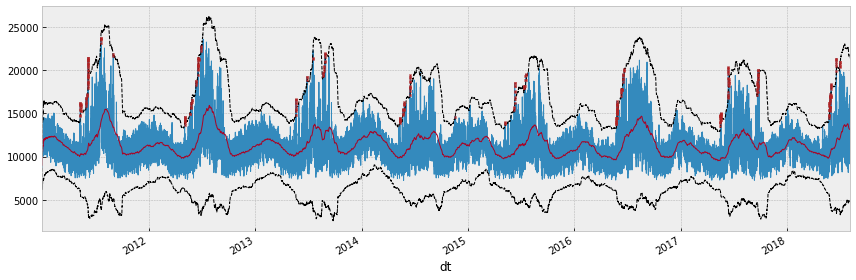

In [44]:
plot_anomalies(data_an, "cons_mw", "cons_mw_rmean", "cons_mw_rstd", "anomaly", 3)

Although some of the caught anomalies look ok, we immediately can spot several problems:
    
- we definitely underestimate the upper boudn of the range, when rolling average goes up very fast,
- we definitely overestimate the upper boudn of the range, when rolling average goes down very fast.

This all happens because rolling average is "delayed" relative to underlying time series. Another, probably more severe, problem is non-stationarity, and especially seasonality. Depending on the structure, by doing such a naive anomaly detection we may miss a lot of real anomalies. Can we do better?

# Extracting trends and seasonality

To make our anomaly search more robust, we can remove trend (if any) and seasonality from the time series:

$$series = trend + seasonality + residuals$$.

In [46]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [61]:
result = seasonal_decompose(data["cons_mw"], freq=365*24)

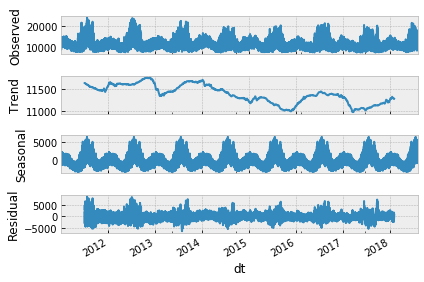

In [48]:
result.plot()
plt.show()

Looks interesting: we have very pronounced seasonality and a lot of information, not covered by season at all (residuals are of the same range, as seasonal component). This may drive us to conclusion, that we can use residuals as the new series for anomaly detection. Let's try.

In [49]:
residual_anomalies = detect_anomalies(result.resid.rename("cons_mw_res"), "30D", 3.)

In [50]:
residual_anomalies.head()

,cons_mw_res,cons_mw_res_rmean,cons_mw_res_rstd,anomaly
dt,,,,
2011-01-01 01:00:00,NaN,NaN,NaN,0
2011-01-01 02:00:00,NaN,NaN,NaN,0
2011-01-01 03:00:00,NaN,NaN,NaN,0
2011-01-01 04:00:00,NaN,NaN,NaN,0
2011-01-01 05:00:00,NaN,NaN,NaN,0


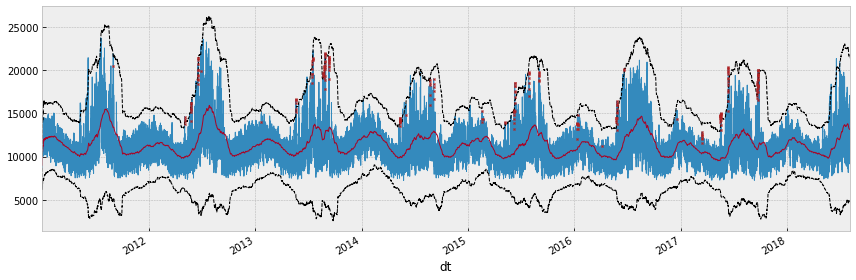

In [51]:
plot_anomalies(data_an.iloc[:, :-1].join(residual_anomalies["anomaly"]),
               "cons_mw", "cons_mw_rmean", "cons_mw_rstd", "anomaly", 3)

What is interesting, is that locations anomalies are different.

# Next steps

Can we somehow explain the anomalies? Or validate them? Yes, we can. Using the [historical weather dataset](https://www.kaggle.com/selfishgene/historical-hourly-weather-data#city_attributes.csv), we can look, whether temperature explains anomalies to some extent and then improve our anomaly detection algrithm.

In [250]:
temperature_file = "./historical-hourly-weather-data/temperature.csv"

In [251]:
temp_data = pd.read_csv(temperature_file, parse_dates=["datetime"],
                        usecols=["datetime", "Chicago"], index_col="datetime")

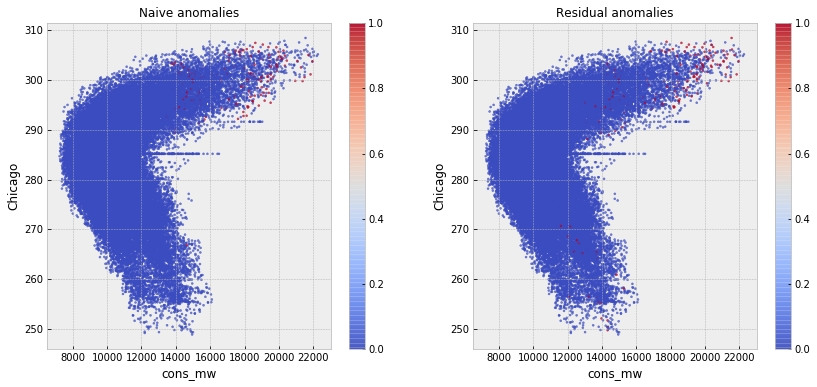

In [252]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
naive_anomalies = temp_data.join(data_an)
naive_anomalies.plot(x="cons_mw", y="Chicago", kind="scatter", s=4, alpha=0.7, c=naive_anomalies.anomaly,
                     cmap=plt.cm.coolwarm, ax=plt.gca())
plt.title("Naive anomalies", fontsize=12)

plt.subplot(1,2,2)
naive_anomalies = naive_anomalies.join(residual_anomalies["anomaly"], rsuffix="_res")
naive_anomalies.plot(x="cons_mw", y="Chicago", kind="scatter", s=4, alpha=0.7, c=naive_anomalies.anomaly_res,
                     cmap=plt.cm.coolwarm, ax=plt.gca())
plt.title("Residual anomalies", fontsize=12);

Btw, can you extract season (summer/winter) from this images? Try to play with some clustering here.

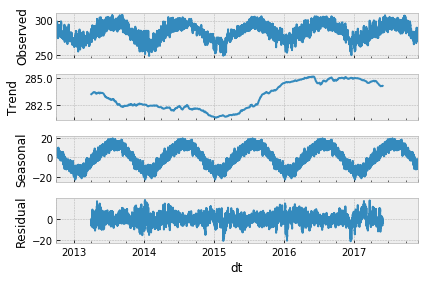

In [86]:
from sklearn.impute import SimpleImputer

temp_data.index.name = "dt"
temp_data.interpolate(method ='linear', limit_direction ='forward', inplace=True) 
temp_data.fillna(method ='bfill', inplace=True)
result = seasonal_decompose(temp_data["Chicago"], freq=365*24)
result.plot()
plt.show()


We (kmean) can split summer/winter around 283 kelvin. This is not totally correct. The official summer in Chicago is June 20 to Sept 22


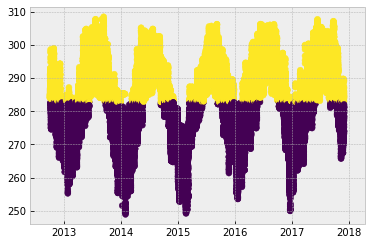

In [143]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=2)
seasons = km.fit_predict(np.array(temp_data["Chicago"]).reshape(-1, 1))
plt.scatter(temp_data.index.date, temp_data["Chicago"], c=seasons)
print("We (kmeans) can split summer/winter around 283 kelvin. This is not totally correct. The official summer in Chicago is June 20 to Sept 22")

Text(0.5, 1.0, 'Season (winter/summer) from the given image')

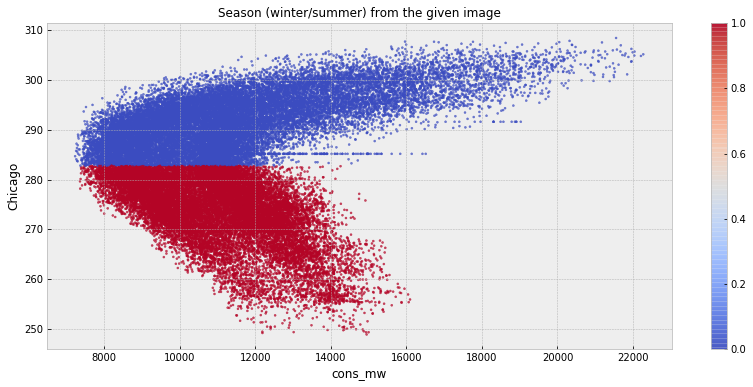

In [144]:
from sklearn.cluster import KMeans

test = temp_data.join(data)
km = KMeans(n_clusters=2)
km.fit(temp_data)
seasons = km.predict(np.array(test["Chicago"]).reshape(-1, 1))
plt.figure(figsize=(14,6))

test.plot(x='cons_mw', y="Chicago", kind="scatter", s=4, alpha=0.7, c=seasons,
                     cmap=plt.cm.coolwarm, ax=plt.gca())
plt.title("Season (winter/summer) from the given image", fontsize=12)

## Intermediate conclusions

We can make two conslusions from the plots above:

- temperature alone is a strong influencer of energy consumption,
- thus, some of the anomalies, that we detected looking only at consumption, are perfectly ok, if you add temperature into consideration.

Let's improve our detection approach, and look at both consumption and temperature. For this, we will use algorithm called Local Outlier Factor detection. In a simple terms, it looks at local density, and tryis to estimate, how strongly a point is embedded into the data.

In [8]:
from sklearn.neighbors import LocalOutlierFactor

In [146]:
en_temp = temp_data.join(data_an)[["Chicago", "cons_mw"]]

In [147]:
en_temp = en_temp[~en_temp.isnull().any(axis=1)]

Let's try default parameters first:

In [148]:
detector = LocalOutlierFactor()
factors = detector.fit_predict(en_temp)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


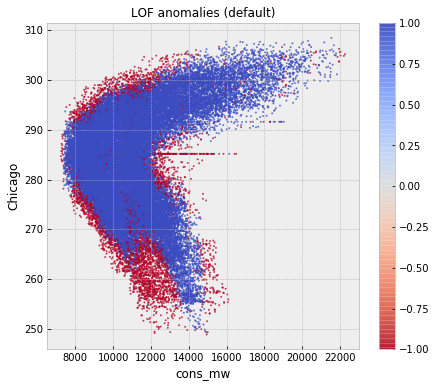

In [149]:
plt.figure(figsize=(7,6))

en_temp.plot(x="cons_mw", y="Chicago", kind="scatter", s=2, alpha=0.7, c=factors,
                     cmap=plt.cm.coolwarm_r, ax=plt.gca())
plt.title("LOF anomalies (default)", fontsize=12);

Not that bas, but it looks like our detector is a bit too harsh. Let's make it softer:

In [150]:
soft_detector = LocalOutlierFactor(contamination=0.025, n_neighbors=10)
factors = soft_detector.fit_predict(en_temp)

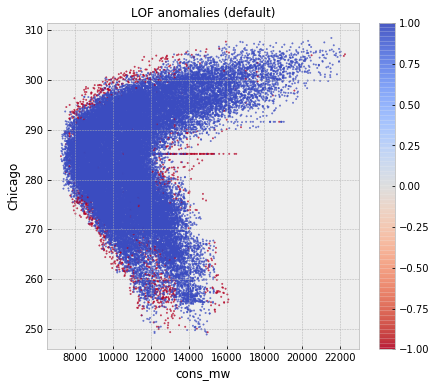

In [151]:
plt.figure(figsize=(7,6))

en_temp.plot(x="cons_mw", y="Chicago", kind="scatter", s=2, alpha=0.7, c=factors,
                     cmap=plt.cm.coolwarm_r, ax=plt.gca())
plt.title("LOF anomalies (default)", fontsize=12);

Contamination parameter defines, how many outliers we have in the data. `0.025` means `once in 40 hours`, which is reasonable, but depends, of course, on which grid operator we consider.

Now that we looked at basics of outlier/anomaly detection, you can play with it further, for example, try IsolationForest algorithm. You may benefit from reading the discussion on how outlier is different from novelty at [`sklearn` User guide](https://scikit-learn.org/stable/modules/outlier_detection.html).

In [9]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(random_state=0, contamination=0.0015).fit(en_temp)
factors = clf.predict(en_temp)


NameError: name 'en_temp' is not defined

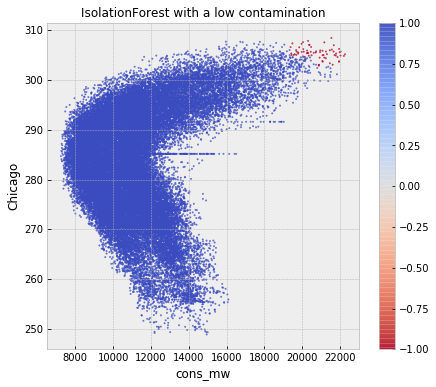

In [170]:

plt.figure(figsize=(7,6))

en_temp.plot(x="cons_mw", y="Chicago", kind="scatter", s=2, alpha=0.7, c=factors,
                     cmap=plt.cm.coolwarm_r, ax=plt.gca())
plt.title("IsolationForest with a low contamination", fontsize=12);

In [171]:
# from sklearn.covariance import EmpiricalCovariance
# from sklearn.ensemble import IsolationForest
# from sklearn.svm import OneClassSVM
# from sklearn.pipeline import Pipeline

# # models = [EmpiricalCovariance(), IsolationForest(random_state=0, contamination=0.0015), OneClassSVM()]
# print("after reading the doc I was curios to try other algo")
# # clf = IsolationForest(random_state=0, contamination=0.0015).fit(en_temp)
# clf = EmpiricalCovariance().fit(en_temp)
# factors = clf.predict(en_temp)

# Structural anomalies

Although you often can spot anomalies just by values, it often happens that anomalies are hidden in data structure. For example, peak frequency of the signal changes, which is sometimes quite hard to spot by eye, or some other **structural** changes take place.

In this case anomalies are detected in a more elaborate way. The most straightforward approach is to somehow quantify signal structure (power spectrum is a good example, as well as mean crossing rate).

We will not go deep into explanations of how this works from medical prospective, and will look at data itself mostly.

In [10]:
mitbih_database_path = "./mitbih-database/"
path_234 = mitbih_database_path + "234.csv"

In [11]:
mit = pd.read_csv(path_234)

In [12]:
mit.head()

,'sample #','MLII','V1'
0,0,1008,1051
1,1,1008,1051
2,2,1008,1051
3,3,1008,1051
4,4,1008,1051


In [13]:
mit.columns = ["sample", "MLII", "V1"]

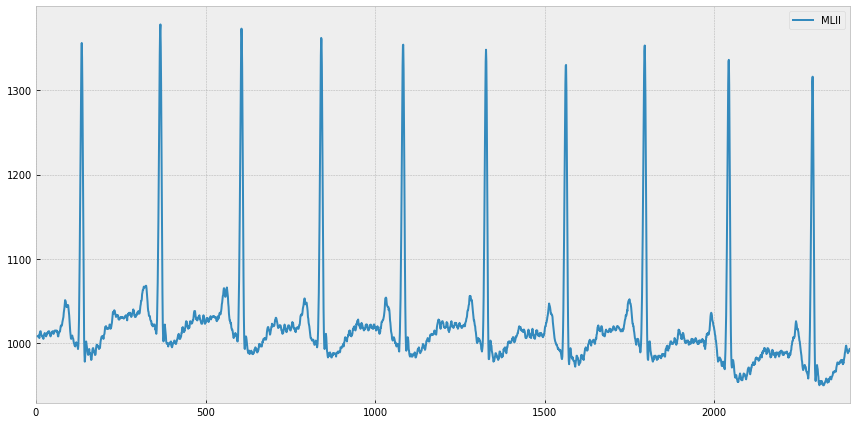

In [14]:
plt.figure(figsize=(12,6))
mit["MLII"].iloc[:2400].plot(legend=True, ax=plt.gca())
plt.tight_layout()

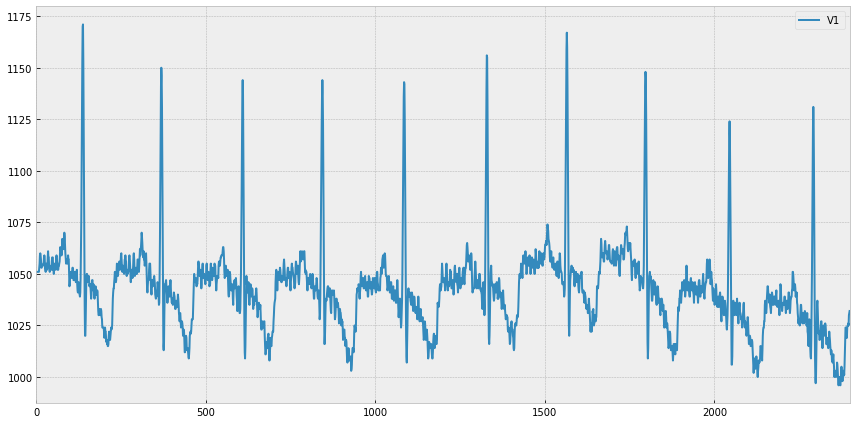

In [15]:
plt.figure(figsize=(12,6))
mit["V1"].iloc[:2400].plot(legend=True, ax=plt.gca())
plt.tight_layout()

As you can see, data has very strong temporal pattern. Failure in following this pattern is an indication of underlying medical condition and can be detected automatically.

In [16]:
annotations234 = mitbih_database_path + "234annotations.txt"

In [17]:
annotations = pd.read_csv(annotations234, sep="\s+")

In [18]:
annotations.head()

,Time,Sample,#,Type,Sub,Chan,Num,Aux
0,0:00.144,52,+,0,0,0,(N,NaN
1,0:00.375,135,N,0,0,0,NaN,NaN
2,0:01.017,366,N,0,0,0,NaN,NaN
3,0:01.683,606,N,0,0,0,NaN,NaN
4,0:02.336,841,N,0,0,0,NaN,NaN


In [19]:
annotations.columns = ["timestamp", "sample", "type", "sub", "chan", "num", "aux", "smth"]

In [20]:
annotations = annotations[annotations.columns[:-1]]

There many approaches to detection of structural anomalies. Depending on the signal, we can

- **construct some aggreagates for rolling windows,** and do the same thing we did with energy consumption. For example, we may calculate peak frequency, or power in some specific spectral band. This approach works well for signals, which do not have strict repetitive structure, but generally have some normal parameters. For example, for rotating (motors, generators, and so on) industrial equipment drift in peak frequency may indicate problems,
- **construct some forecasting model,** and look at large deviations between forecasts and real values. This works well for a) signals with autoregressive structure (energy consumption is a good example), and hence the model is some kind of AR model (AR, VAR, ARIMA, whatever works), b) for signals with clear and repetitive structure (ECG and EEG are good examples), and in this case we need to build a nonlinear model for forecasting.

Since we have a signal with very strict temporal pattern, we may try to model it and look at divergence between what model predicts (i.e. the temporal structure model catched) and real values.

We will take last 50 values (this number is a bit out of the blue, but if you look at signal, you'll see, that it should be ok).

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [22]:
train_signal = mit[:30000]
cv_signal = mit[:30050]
test_signal = mit[40050:50000]

We won't go into hyperparameters tuning, we only need to know, that our model cross-validaties.

In [23]:
WINDOW = 50

In [24]:
signal = mit[:15000]

In [25]:
features = {}

for i in signal.index[50:]:
    fts = (signal.loc[i-WINDOW:i-1, ["MLII", "V1"]]
           .reset_index(drop=True)
           .stack(dropna=False)
           .to_frame()
           .reset_index())
    fts.index = fts.level_1.str.cat(fts.level_0.astype(str), sep="_")
    features[i] = fts.loc[:, 0]
features = pd.DataFrame.from_dict(features, orient="index")

In [26]:
features.head()

,MLII_0,V1_0,MLII_1,V1_1,MLII_2,V1_2,MLII_3,V1_3,MLII_4,V1_4,...,MLII_45,V1_45,MLII_46,V1_46,MLII_47,V1_47,MLII_48,V1_48,MLII_49,V1_49
50,1008,1051,1008,1051,1008,1051,1008,1051,1008,1051,...,1011,1052,1012,1056,1013,1058,1013,1058,1014,1058
51,1008,1051,1008,1051,1008,1051,1008,1051,1008,1051,...,1012,1056,1013,1058,1013,1058,1014,1058,1014,1052
52,1008,1051,1008,1051,1008,1051,1008,1051,1008,1051,...,1013,1058,1013,1058,1014,1058,1014,1052,1011,1052
53,1008,1051,1008,1051,1008,1051,1008,1051,1008,1051,...,1013,1058,1014,1058,1014,1052,1011,1052,1011,1050
54,1008,1051,1008,1051,1008,1051,1008,1051,1009,1051,...,1014,1058,1014,1052,1011,1052,1011,1050,1012,1054


In [27]:
features.shape

(14950, 100)

In [28]:
model = RandomForestRegressor(n_estimators=500, max_depth=4)
model.fit(features[:7500], signal.loc[features[:7500].index, "V1"])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [204]:
print("CV MSE:", mean_squared_error(model.predict(features[7500:10000]),
                                    signal.loc[features[7500:10000].index, "V1"]))

CV MSE: 31.723106926569955


Ok, looks like it works just fine, let's look at forecasts:

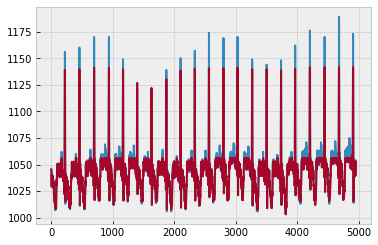

In [205]:
plt.plot(signal.loc[features[10000:].index, "V1"].values)
plt.plot(model.predict(features[10000:]))

We see, that model is not ideal, but we do not plan to use it directly. Instead, we will look at longer time intervals:

In [206]:
indicator = pd.DataFrame(np.vstack([signal.loc[features[10000:].index, "V1"].values,
                                    model.predict(features[10000:])]).T,
                        columns = ["y_true", "y_pred"], index=features[10000:].index)

In [207]:
indicator["y_diff"] = (indicator["y_true"]-indicator["y_pred"]).abs()

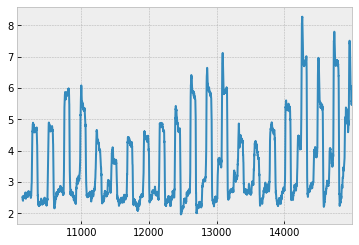

In [208]:
indicator["y_diff"].rolling(80).mean().plot()

Now, by thresholding the rolling averages difference between forecast and actual values, we can detect anomalous behaviour.

# Assignment

1. Calculate features for a longer period of time, so that model can be trained to better match the real signal,
2. Calculate differences and assess, whether they are ok to serve as anomaly detection,
3. Try to understand, why we use rolling average instead of difference between forecast and actual values,
4. Can you implement the same approach to energy consumption problem?

#### Answer q1

I was about to use a train, CV, test dataset but it was not used in the given exemple. It was just asked to increase the period of the trainning


fitting...
CV MSE: 28.724591637892324
plotting...


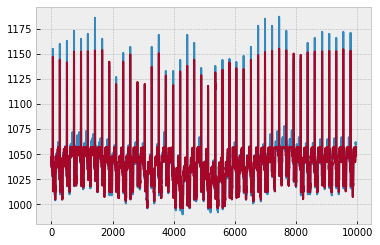

In [30]:
from tqdm.auto import tqdm

factor = 2
# dataset_size = 15000 # should use it to remove the hard coded values given in the exemple
if 1 <= factor < 43:
    signal = mit[:int(15000 * factor)]
    features = {}

    for i in tqdm(signal.index[50:]):
        fts = (signal.loc[i-WINDOW:i-1, ["MLII", "V1"]]
               .reset_index(drop=True)
               .stack(dropna=False)
               .to_frame()
               .reset_index())
        fts.index = fts.level_1.str.cat(fts.level_0.astype(str), sep="_")
        features[i] = fts.loc[:, 0]
    features = pd.DataFrame.from_dict(features, orient="index")
    model = RandomForestRegressor(n_estimators=500, max_depth=4)
    print("fitting...")
    model.fit(features[:int(7500 * factor)], signal.loc[features[:int(7500 * factor)].index, "V1"])
    print("CV MSE:", mean_squared_error(model.predict(features[int(7500 * factor):int(10000 * factor)]),
                                        signal.loc[features[int(7500 * factor):int(10000 * factor)].index, "V1"]))
    print("plotting...")
    plt.plot(signal.loc[features[int(10000 * factor):].index, "V1"].values)
    plt.plot(model.predict(features[int(10000 * factor):]))
else:
    print(f"factor:{factor} should be between 1 and 43")

#### Answer q2

Text(0.5, 1.0, 'Rolling average of the diffence')

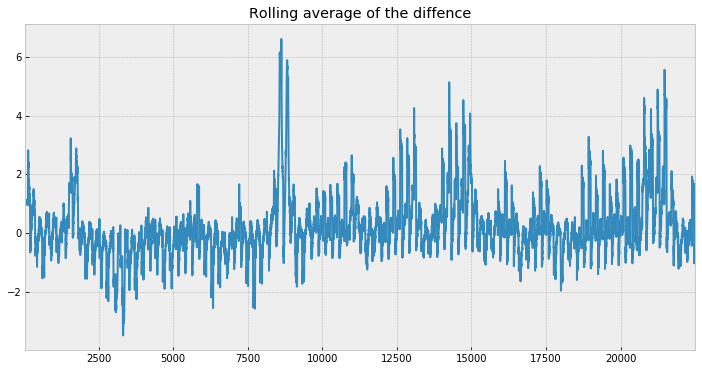

In [238]:
rolling_period = 70
indicator = pd.DataFrame(np.vstack([signal.loc[features.index, "V1"].values,
                                    model.predict(features)]).T,
                        columns = ["y_true", "y_pred"], index=features.index)

# indicator = pd.DataFrame(np.vstack([signal.loc[int(7500 * factor), "V1"].values,
#                                     model.predict(features[int(7500 * factor):int(10000 * factor)]]).T,
#                         columns = ["y_true", "y_pred"], index=features.index)


# features[int(7500 * factor):int(10000 * factor)]
indicator["y_diff"] = (indicator["y_true"]-indicator["y_pred"])
plt.figure(figsize=(12,6))
indicator["y_diff"].rolling(rolling_period).mean().plot()
plt.title("Rolling average of the diffence")

We can see y_pred is very close to y_true

#### Answer 3

By using a rolling average we are smoothing the prediction. We let the values vary in a relevant range. 
We also keept our system detect anomalies.

#### Answer 4


Fitting
CV MSE: 228086.88957673893


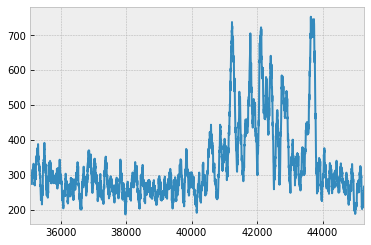

In [242]:
from tqdm.auto import tqdm

WINDOW = 50
training_size = 25000
predict_size = 35000
rolling_update = 70

features = {}
nrg = en_temp.copy()
nrg.reset_index(inplace=True)
for i in tqdm(nrg.index[WINDOW:]):
    fts = (nrg.loc[i-WINDOW:i-1, ["Chicago", "cons_mw"]]
           .reset_index(drop=True)
           .stack(dropna=False)
           .to_frame()
           .reset_index())
    fts.index = fts.level_1.str.cat(fts.level_0.astype(str), sep="_")
    features[i] = fts.loc[:, 0]
features = pd.DataFrame.from_dict(features, orient="index")
model_nrg = RandomForestRegressor(n_estimators=500, max_depth=4)
print("Fitting")
model_nrg.fit(features[:training_size], nrg.loc[features[:training_size].index, "cons_mw"])
print("CV MSE:", mean_squared_error(model_nrg.predict(features[training_size:predict_size]),
                                    nrg.loc[features[training_size:predict_size].index, "cons_mw"]))
indicator_nrg = pd.DataFrame(np.vstack([nrg.loc[features[predict_size:].index, "cons_mw"].values,
                                    model_nrg.predict(features[predict_size:])]).T,
                        columns = ["y_true", "y_pred"], index=features[predict_size:].index)
indicator_nrg["y_diff"] = (indicator_nrg["y_true"] - indicator_nrg["y_pred"]).abs()
indicator_nrg["y_diff"].rolling(rolling_update).mean().plot()